## FIFO load balancer

In [1]:
import pandas as pd
import json
import os
import numpy as np

In [2]:
pathNN = '/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balanceNN2'
pathPLAN = '/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balance_planRGCN2'

In [3]:
def extract_qs(path):
    qs = []
    for p in os.listdir(path):
        if p == "main.json":
            continue
        if not p.endswith('.json'):
            continue
        try:
            print(f"{path}/{p}")
            data = json.load(open(f"{path}/{p}",'r'))
            for q in data:
                q_data = json.loads(q['query'])
                for k in q_data.keys():
                    q[k] = q_data[k]
                q['ex_time'] = q['query_execution_end'] - q['query_execution_start']
                q['latency'] = q['query_execution_end'] - q['arrival_time']
                q['queue_wait_time'] = q['query_execution_start'] - q['queue_arrival_time']
                qs.append(q)
        except Exception as e:
            print(f"Non working{path}/{p}")
    return qs
NN = extract_qs(pathNN)
plan = extract_qs(pathPLAN)
data = {'Algebra & GED-based NN':NN, 'PlanRGCN': plan}
len(NN), len(plan)

/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balanceNN2/fast3.json
/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balanceNN2/fast4.json
/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balanceNN2/med2.json
/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balanceNN2/fast2.json
/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balanceNN2/med3.json
/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balanceNN2/med1.json
/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balanceNN2/fast1.json
/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balanceNN2/slow1.json
/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balance_planRGCN2/fast3.json
/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balance_planRGCN2/fast4.json
/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balance_planRGCN2/med2.json
/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balance_planRGCN2/fast2.json
/data/qpp2_data/DBpedia2016_0_1_10_weight_loss/load_balance_planRGCN2/med3.json
/data/qp

(1816, 1777)

In [4]:
NN[0]

{'query': '{"ID": "http://lsq.aksw.org/lsqQuery-YC3kosiDaNHFTsQHfpbSJvE2AfX-RjnPKRZlh_mUso8LIMIT", "text": "PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> PREFIX dbpo: <http://dbpedia.org/ontology/> PREFIX foaf: <http://xmlns.com/foaf/0.1/> SELECT DISTINCT ?person ?object ?deathDate ?wikipedia WHERE { ?object dbpo:deathDate ?deathDate ; rdfs:label ?person FILTER ( ( ?deathDate > \\"1908-04-12\\"^^xsd:date ) && ( ?deathDate < \\"1908-04-14\\"^^xsd:date ) ) FILTER ( lang(?person) = \\"en\\" ) ?object foaf:isPrimaryTopicOf ?wikipedia } ", "true_interval": "0"}',
 'start_time': 1706033724.5072286,
 'arrival_time': 1706033724.6162317,
 'queue_arrival_time': 1706033724.616293,
 'query_execution_start': 1706033724.6170046,
 'query_execution_end': 1706033724.6452837,
 'execution_time': 0.02827906608581543,
 'response': 'ok',
 'ID': 'http://lsq.aksw.org/lsqQuery-YC3kosiDaNHFTsQHfpbSJvE2AfX-RjnPKRZlh_mUso8LIMIT',
 'text': 'PREFIX xsd: <http:/

In [5]:
print("Time outs")
print(f"NN LB Timeouts : {np.sum([1 for x in NN if x['response'] == 'timed out'])}")
print(f"PlanRGCN LB Timeouts : {np.sum([1 for x in plan if x['response'] == 'timed out'])}")

Time outs
NN LB Timeouts : 50
PlanRGCN LB Timeouts : 31


In [6]:
print("Good Queries")
print(f"NN LB Good Queries : {np.sum([1 for x in NN if x['response'] == 'ok'])}")
print(f"Plan LB Good Queries : {np.sum([1 for x in plan if x['response'] == 'ok'])}")

Good Queries
NN LB Good Queries : 1766
Plan LB Good Queries : 1746


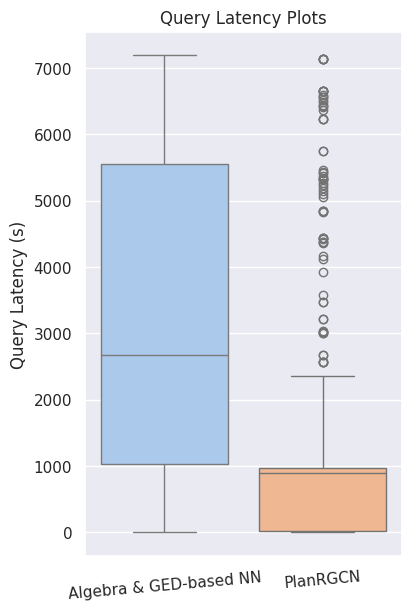

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='pastel',color_codes = True)

def plot_box_latency(dct, figsize=(4,6)):
    fig, ax = plt.subplots(layout='constrained', figsize=figsize)
    for k in dct.keys():
        ax = sns.boxplot(y=[q['latency'] for q in dct[k]],x=[k for q in dct[k]], ax=ax)
    #ax = sns.boxplot(y=[q['latency'] for q in qpp_lb],x=['PlanRGCN Load Balancer' for q in qpp_lb], ax=ax)
    ax.set_ylabel('Query Latency (s)')
    ax.set_title("Query Latency Plots")
    ax.tick_params(axis='x', rotation=5)
    plt.show()
    
def plot_box_ex_time(dct, figsize=(4,4)):
    fig, ax = plt.subplots(layout='constrained', figsize=figsize)
    for k in dct.keys():
        ax = sns.boxplot(y=[q['ex_time'] for q in dct[k]],x=[k for q in dct[k]], ax=ax)
    ax.tick_params(axis='x', rotation=5)
    plt.show()
    
plot_box_latency(data)

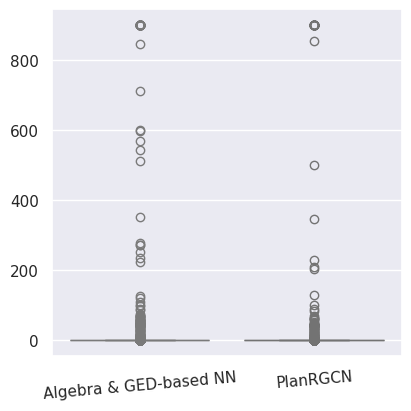

In [8]:
plot_box_ex_time(data)

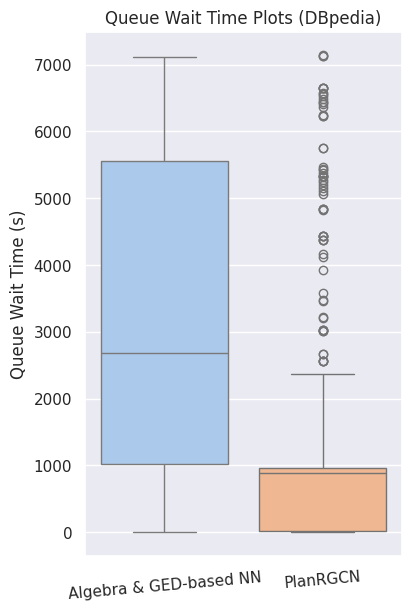

In [9]:
def plot_box_queu_wait_time(dct, figsize=(4,6)):
    fig, ax = plt.subplots(layout='constrained', figsize=figsize)
    for k in dct.keys():
        ax = sns.boxplot(y=[q['queue_wait_time'] for q in dct[k]],x=[k for q in dct[k]], ax=ax)
    ax.set_ylabel('Queue Wait Time (s)')
    ax.set_title("Queue Wait Time Plots (DBpedia)")
    ax.tick_params(axis='x', rotation=5)
    plt.show()
plot_box_queu_wait_time(data)

In [10]:
for k in data.keys():
    print(f"Average Queue Wait Time '{k}' {np.mean([x['queue_wait_time'] for x in data[k]])}")

Average Queue Wait Time 'Algebra & GED-based NN' 3254.4927113331887
Average Queue Wait Time 'PlanRGCN' 670.5149391886218


Algebra & GED-based NN__________
25%  0.9999547766750282
mean  0.9628505928143927
75%  0.999995263182749
PlanRGCN__________
25%  0.9990148841406177
mean  0.97921408490351
75%  0.9999733972859681


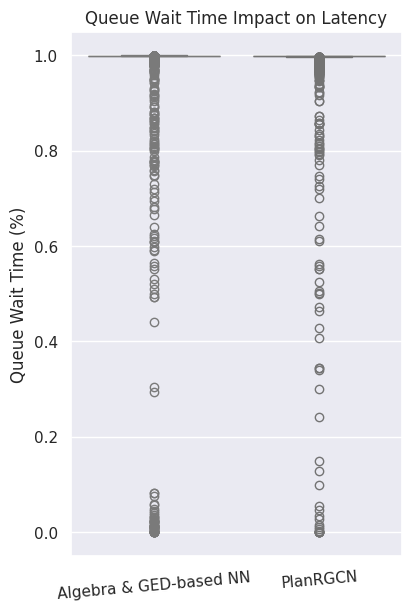

In [11]:
def plot_box_queu_wait_time_percentage(dct, figsize=(4,6)):
    fig, ax = plt.subplots(layout='constrained', figsize=figsize)
    for k in dct.keys():
        k_queu_wait_time = [q['queue_wait_time']/q['latency'] for q in dct[k]]
        print(f'{k}__________')
        print("25% ",np.quantile(k_queu_wait_time,q=0.25))
        print("mean ", np.mean(k_queu_wait_time))
        print("75% ", np.quantile(k_queu_wait_time,q=0.75))
        ax = sns.boxplot(y=k_queu_wait_time,x=[k for q in dct[k]], ax=ax)
    ax.set_ylabel('Queue Wait Time (%)')
    ax.set_title("Queue Wait Time Impact on Latency")
    ax.tick_params(axis='x', rotation=5)
    plt.show()
plot_box_queu_wait_time_percentage(data)

In [12]:
def calculate_total_latency(qs):
    sum = 0
    for q in qs:
        sum += q['latency']
    return sum
for k in data.keys():
    print(f"{k}:  {calculate_total_latency(data[k])/len(data[k])}")

Algebra & GED-based NN:  3284.837566025194
PlanRGCN:  688.8993081296503


In [13]:
#lat_total_fifo/len(fifo), lat_total_qpp/len(qppBalance)

In [14]:
#avg_fifo =lat_total_fifo/len(fifo)
#avg_qpp = lat_total_qpp/len(qppBalance)
#relative_impro = ((lat_total_qpp-lat_total_fifo)/lat_total_fifo)*100
#relative_impro

In [15]:
#((lat_total_fifo-lat_total_qpp)/lat_total_qpp)*100

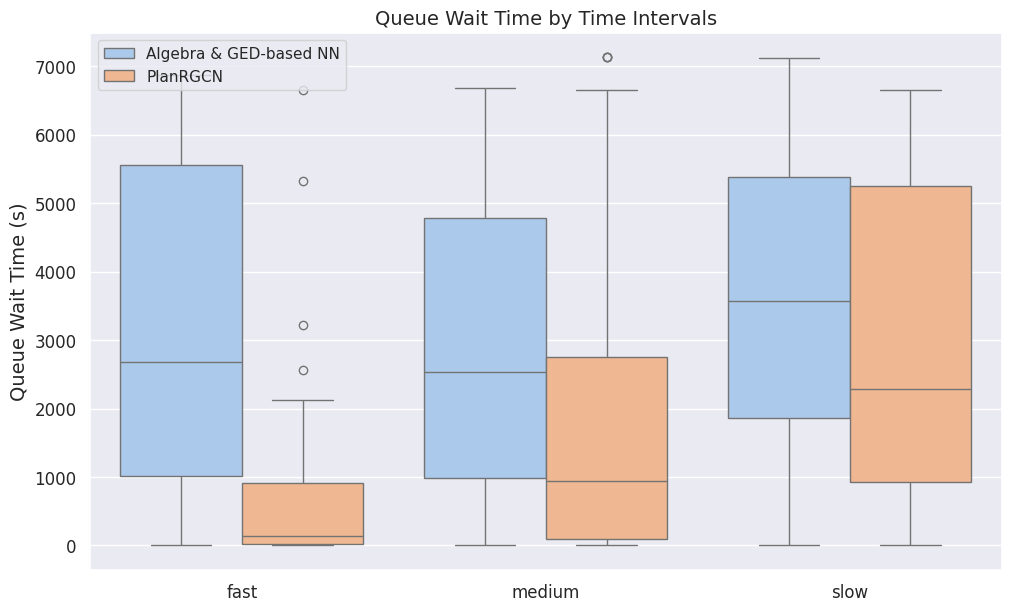

In [16]:
import pandas as pd

def plot_box_queu_wait_time_int(dct, figsize=(4,6)):
    load_balancer = []
    que_w_time = []
    runtime_interval = []
    for k in dct.keys():
        for q in dct[k]:
            load_balancer.append(k)
            que_w_time.append(q['queue_wait_time'])
            match q['true_interval']:
                case '0':
                    runtime_interval.append('fast')
                case '1':
                    runtime_interval.append('medium')
                case '2':
                    runtime_interval.append('slow')
    
    df = pd.DataFrame.from_dict({'Approach': load_balancer, 'Runtime Interval':runtime_interval, 'queue wait time':que_w_time})
    figsize=(10,6)
    fig, ax = plt.subplots(layout='constrained', figsize=figsize)
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax = sns.boxplot(x='Runtime Interval',y='queue wait time',data=df,hue='Approach', ax =ax, order=['fast', 'medium', 'slow'])
    ax.set_xlabel("")
    ax.set_title('Queue Wait Time by Time Intervals', fontsize=14)
    ax.set_ylabel("Queue Wait Time (s)", fontsize=14)
    ax.legend(loc=2)
    
plot_box_queu_wait_time_int(data)